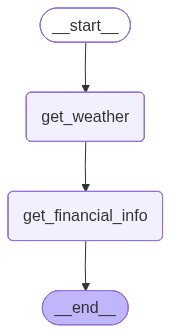

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict


class AgentState(TypedDict):
    user: str


graph_builder = StateGraph(AgentState)


def get_weather(city: str):
    return None


def get_financial_info(stock: str):
    return None


graph_builder.add_node("get_weather", get_weather)
graph_builder.add_node("get_financial_info", get_financial_info)

graph_builder.add_edge(START, "get_weather")
graph_builder.add_edge("get_weather", "get_financial_info")
graph_builder.add_edge("get_financial_info", END)

graph = graph_builder.compile()

graph

In [4]:
graph.invoke({})